In [29]:
import os
import keras
import logging
import numpy as np
from imageio import imread
from keras.models import Model
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.optimizers import Adam
from PIL import Image, ImageFilter
from keras.models import Sequential
from keras.engine.topology import Layer
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate

%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

### Dataset managment

In [30]:
def download_ds(download_address, save_address):
    if os.path.exists(save_address):
        logger.info("The dataset has already been downloaded.")
    else:
        !wget -O ds.zip {download_address}
        !unzip ds.zip
        !mv ShapesData_few-show-learning {save_address}
        !find {save_address} -name '*.DS_Store' -delete

In [31]:
class DS:
    def __init__(self):
        self.x_tr = None
        self.y_tr = None
        self.labels_tr = None
        self.x_val = None
        self.Y_val = None
        self.labels_val = None
        self.x_eval = None
        self.y_eval = None
        self.labels_eval = None
        self.names_tr = []
        self.names_val = []
        self.names_eval = []
        #self.labels_dict = None

    def __Load_data(self,address, new_im_size, train_ratio,channel_type="RGB"):
        class_count = len(os.listdir(address))
        train_count = int(class_count*train_ratio)
        train_idx = np.random.choice(class_count, size = train_count, replace = False)
        x_tr, y_tr, x_val, y_val, names_tr, names_val = [],[],[],[], [], []
        #labels_idx = dict()
        labels_tr = []
        labels_val = []
        offset_tr, offset_val = 0,0
        if os.path.exists(os.path.join(address,".DS_Store")):
            os.remove(os.path.join(address, ".DS_Store"))
        for i , label in enumerate(os.listdir(address)):
            labels_address = os.path.join(address, label)
            x, y, labels, names = (x_tr, y_tr, labels_tr, names_tr) if i in train_idx else (x_val, y_val, labels_val, names_val)
            #labels_idx[i] = label
            for image_name in os.listdir(labels_address):
                image_address = os.path.join(labels_address, image_name)
                try:
                    img = Image.open(image_address).convert(channel_type)
                    img = img.resize((new_im_size, new_im_size))
                    x.append(np.array(img, dtype=np.float32))
                    y.append(i)
                except:
                    logger.info("ERROR: can't load {}".format(image_address))
            label_count = len(os.listdir(labels_address))
            names.append(label)
            if i in train_idx:
                labels.append((i, label_count , offset_tr))
                offset_tr+=label_count
            else:
                labels.append((i, label_count , offset_val))
                offset_val+=label_count

        x_tr = np.array(x_tr)
        y_tr = np.array(y_tr)
                
        x_val = np.array(x_val)
        y_val = np.array(y_val)

        if class_count-train_count > 0:
            x_val = np.array(x_val)
            y_val = np.array(y_val)

        return x_tr, y_tr, np.array(labels_tr), names_tr, x_val, y_val, np.array(labels_val), names_val

    def Load_evaluation(self, address, new_im_size,channel_type="RGB"):
        self.x_eval, self.eval, self.labels_eval,self.names_eval, _, _, _, _ =self.__Load_data(address, new_im_size, 1, channel_type)

    def Load_background(self,address, new_im_size, train_ratio, channel_type="RGB"):
        self.x_tr, self.y_tr, self.labels_tr,self.names_tr, self.x_val, self.y_val, self.labels_val, self.names_val=self.__Load_data(address, new_im_size, train_ratio, channel_type)
    
    def get_paired_data(self,batch_size, x, labels):
        half_size = batch_size // 2
        class_count = labels.shape[0]
        rnd_classes = np.random.choice(class_count, size = half_size, replace = True)
        rnd_pos_classes_lbl =labels[rnd_classes]
        rnd_1 = (np.random.uniform(0,1, half_size)*rnd_pos_classes_lbl[:,1]+rnd_pos_classes_lbl[:,2]).astype(np.int32)
        rnd_pos_2 = (np.random.uniform(0,1, half_size)*rnd_pos_classes_lbl[:,1] +rnd_pos_classes_lbl[:,2]).astype(np.int32)

        rnd_neg_2_classes =  (rnd_classes + np.random.randint(1,class_count-1,half_size)) % class_count
        rnd_neg_classes_lbl =labels[rnd_neg_2_classes]
        rnd_neg_2 = (np.random.uniform(0,1, half_size)*rnd_neg_classes_lbl[:,1]+rnd_neg_classes_lbl[:,2]).astype(np.int32)

        pair_1 = x[np.repeat(rnd_1,2)]
        pair_2 = np.concatenate((x[rnd_pos_2], x[rnd_neg_2]))
        y = np.ones(half_size*2)
        y[half_size:]= 0
        return [pair_1, pair_2], y

    def get_paired_train(self, batch_size):
        while True:
            yield self.get_paired_data(batch_size, self.x_tr, self.labels_tr)

    def get_paired_val(self, batch_size):
        while True:
            return self.get_paired_data(batch_size, self.x_val, self.labels_val)
    
    def get_paired_one_shot_eval(self,x, labels, class_idx):
        class_count = labels.shape[0]
        class_spec = labels[class_idx]
        pair_1 = np.zeros((class_count, x.shape[1], x.shape[2], x.shape[3]))
        pair_2 = np.zeros((class_count, x.shape[1], x.shape[2], x.shape[3]))
        rnd1 = (np.random.uniform(0,1, 1)*class_spec[1]+class_spec[2]).astype(np.int32)
        rnd1_repeated = np.repeat(rnd1, class_count)
        pair_1[:,:,:,:] = x[rnd1_repeated]
        classes = np.arange(class_count)
        rnd2 = (np.random.uniform(0,1, class_count)*labels[:,1]+labels[:,2]).astype(np.int32)
        pair_2[:,:,:,:] = x[rnd2]
        
        y = np.zeros(class_count)
        y[class_idx] = 1
        return [pair_1, pair_2], y  
        
    def normalize(self):
        self.x_tr= self.x_tr /255
        self.x_val= self.x_val / 255
        self.x_eval= self.x_eval / 255

    def standardize_images(self,x):
        if x is None:
            return None
        means = np.mean(x, axis=0)
        stds = np.std(x, axis=0)
        return (x-means)/stds

    def standardize_ds(self):
        self.x_tr = self.standardize_images(self.x_tr)
        self.x_val = self.standardize_images(self.x_val)
        self.x_eval = self.standardize_images(self.x_eval)

    def reshape(self):
        if self.x_tr is not None and len(self.x_tr.shape)<4:
            self.x_tr = self.x_tr.reshape(*self.x_tr.shape,1)
        if self.x_eval is not None and len(self.x_eval.shape)<4:
            self.x_eval = self.x_eval.reshape(*self.x_eval.shape,1)
        if self.x_val is not None and len(self.x_val.shape)<4:
            self.x_val = self.x_val.reshape(*self.x_val.shape,1)




### Model

In [32]:
def siamese(input_shape):
    init_b = keras.initializers.RandomNormal(mean = 0.5, stddev=0.01)
    init_w = keras.initializers.RandomNormal(mean = 0.0, stddev=0.01)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',kernel_regularizer=l2(1e-3), kernel_initializer=init_w,bias_initializer=init_b))
    dense_layer = Dense(1,activation='sigmoid',bias_initializer=init_b)
    L1_layer = Lambda(lambda tensors:keras.backend.abs(tensors[0] - tensors[1]))
    input_1, input_2 = Input(input_shape), Input(input_shape)
    outputs = dense_layer(L1_layer([model(input_1), model(input_2)]))
    siamese_model = Model(inputs=[input_1,input_2],outputs=outputs)
    return siamese_model


In [33]:
'''
print(batch1_ds.labels)
print(batch1_ds.x_tr.shape)
print(batch1_ds.y_tr.shape)
print(batch1_ds.labels_tr)
print(batch1_ds.x_val.shape)
print(batch1_ds.y_val.shape)
print(batch1_ds.labels_val)
'''

'\nprint(batch1_ds.labels)\nprint(batch1_ds.x_tr.shape)\nprint(batch1_ds.y_tr.shape)\nprint(batch1_ds.labels_tr)\nprint(batch1_ds.x_val.shape)\nprint(batch1_ds.y_val.shape)\nprint(batch1_ds.labels_val)\n'

In [47]:
def load_evaluation_folder(address, new_im_size, channel_type="RGB"):
    ds_list = []
    for file_name in os.listdir(address):
        folder_address = os.path.join(address, file_name)
        for folder_name in os.listdir(folder_address):
            ds = DS()
            ds.Load_evaluation(os.path.join(folder_address, folder_name),new_im_size, channel_type)
            ds.reshape()
            ds_list.append([ds,file_name+'/'+folder_name])
    return ds_list

In [35]:
def eval_siamese(model,ds, count):
    class_count = ds.labels_eval.shape[0]
    corrects = np.zeros(class_count)
    per_class = np.zeros(class_count)
    for i in range(count):
        pairs, y = ds.get_paired_one_shot_eval(ds.x_eval, ds.labels_eval, i%class_count)
        predictions = model.predict(pairs)
        
        corrects[i%class_count] += np.argmax(predictions) == np.argmax(y)
        per_class[i%class_count] += 1
    acc = corrects/per_class
    return acc, np.average(acc)

In [36]:
def evaluate_list(model, ds_list, count):
    for ds, name in ds_list:
        acc, acc_avg = eval_siamese(model,ds, count)
        print("______________________________")
        print("Evaluation for {}: avg acc={}".format(name, acc_avg))
        for i, label in enumerate(ds.names_eval):
            print("the accuracy for {}: {}".format(label, acc[i]))

In [37]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Batch1

Download and load

In [38]:
bg_download_address = "https://www.dropbox.com/s/9imgl9m0qzin55g/ShapesData_few-show-learning.zip?dl=0"
bg_save_address = "dataset"
eval_download_address = "https://www.dropbox.com/s/bhk86noqwollrs9/new_data.zip?dl=1"
eval_save_address = "new_data"
new_im_size = 105
download_ds(bg_download_address, bg_save_address)
download_ds(eval_download_address, eval_save_address)
batch1_address = os.path.join(bg_save_address, "batch1")
batch1_ds = DS()
batch1_ds.Load_background(batch1_address, 105, 0.7)
eval_list = load_evaluation_folder(eval_save_address, new_im_size)

#batch1_ds.normalize()
#batch1_ds.standardize_ds()

Creating the model

In [ ]:
model = siamese((new_im_size, new_im_size, 3))
model.summary()
optimizer = Adam(lr = 0.00006)

model.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38960448    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

Train

In [ ]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history =model.fit_generator(generator=batch1_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = batch1_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 4.5165 - val_loss: 4.5087
Epoch 2/2000
1/1 [==============================] - 0s 95ms/step - loss: 4.5249 - val_loss: 4.4934
Epoch 3/2000
1/1 [==============================] - 0s 97ms/step - loss: 4.4821 - val_loss: 4.4713
Epoch 4/2000
1/1 [==============================] - 0s 96ms/step - loss: 4.4751 - val_loss: 4.4547
Epoch 5/2000
1/1 [==============================] - 0s 97ms/step - loss: 4.4470 - val_loss: 4.4363
Epoch 6/2000
1/1 [==============================] - 0s 99ms/step - loss: 4.4064 - val_loss: 4.4213
Epoch 7/2000
1/1 [==============================] - 0s 97ms/step - loss: 4.4241 - val_loss: 4.4087
Epoch 8/2000
1/1 [==============================] - 0s 97ms/step - loss: 4.4018 - val_loss: 4.3982
Epoch 9/2000
1/1 [==============================] - 0s 97ms/step - loss: 4.3836 - val_loss: 4.3915
Epoch 10/2000
1/1 [==============================] - 0s 101ms/step - loss: 4.4282 - val_loss: 4.3831
Epoch 11/2

In [ ]:
plot_history(history)

Evaluation

In [ ]:
evaluate_list(model, eval_list, 100)

______________________________
Evaluation for naturale/camera: avg acc=0.8
the accuracy for tree: 0.7
the accuracy for bat: 0.6
the accuracy for monkey: 0.8
the accuracy for house: 0.8
the accuracy for girl: 0.8
the accuracy for car: 0.9
the accuracy for if: 0.8
the accuracy for boy: 1.0
the accuracy for crocodile: 0.9
the accuracy for lion: 0.7
______________________________
Evaluation for naturale/cellulare: avg acc=0.7100000000000001
the accuracy for tree: 0.8
the accuracy for bat: 0.5
the accuracy for monkey: 0.7
the accuracy for house: 0.8
the accuracy for girl: 0.3
the accuracy for car: 1.0
the accuracy for if: 0.8
the accuracy for boy: 0.8
the accuracy for crocodile: 0.5
the accuracy for lion: 0.9
______________________________
Evaluation for artificiale/camera: avg acc=0.69
the accuracy for tree: 0.6
the accuracy for bat: 0.7
the accuracy for monkey: 0.7
the accuracy for house: 0.6
the accuracy for girl: 0.4
the accuracy for car: 0.9
the accuracy for if: 0.5
the accuracy for bo

###Batch2

Loading the data

In [48]:
new_im_size = 105
batch2_address = os.path.join(bg_save_address, "batch2_gray")
batch2_ds = DS()
batch2_ds.Load_background(batch2_address, 105, 0.7, "L")
batch2_ds.reshape()
eval_list_gray = load_evaluation_folder(eval_save_address, new_im_size,"L")

creating a new model

In [42]:
model2 = siamese((new_im_size, new_im_size, 1))
model2.summary()
optimizer2 = Adam(lr = 0.00006)
model2.compile(loss="binary_crossentropy",optimizer=optimizer2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]         

In [44]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history2 =model2.fit_generator(generator=batch2_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = batch2_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 7s 7s/step - loss: 4.5233 - val_loss: 4.5163
Epoch 2/2000
1/1 [==============================] - 0s 191ms/step - loss: 4.5453 - val_loss: 4.4873
Epoch 3/2000
1/1 [==============================] - 0s 193ms/step - loss: 4.4886 - val_loss: 4.4627
Epoch 4/2000
1/1 [==============================] - 0s 188ms/step - loss: 4.4597 - val_loss: 4.4442
Epoch 5/2000
1/1 [==============================] - 0s 194ms/step - loss: 4.4594 - val_loss: 4.4278
Epoch 6/2000
1/1 [==============================] - 0s 190ms/step - loss: 4.4407 - val_loss: 4.4116
Epoch 7/2000
1/1 [==============================] - 0s 191ms/step - loss: 4.4243 - val_loss: 4.3974
Epoch 8/2000
1/1 [==============================] - 0s 189ms/step - loss: 4.3764 - val_loss: 4.3813
Epoch 9/2000
1/1 [==============================] - 0s 187ms/step - loss: 4.3710 - val_loss: 4.3697
Epoch 10/2000
1/1 [==============================] - 0s 191ms/step - loss: 4.3605 - val_loss: 4.3566
Ep

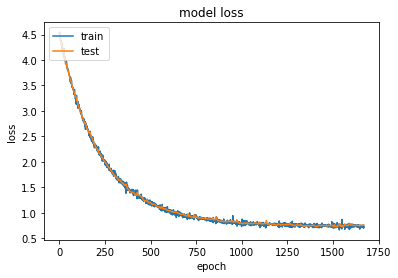

In [49]:
plot_history(history2)

Evaluate

In [51]:
evaluate_list(model2, eval_list_gray, 100)

______________________________
Evaluation for naturale/camera: avg acc=0.8100000000000002
the accuracy for tree: 1.0
the accuracy for bat: 0.8
the accuracy for monkey: 0.8
the accuracy for house: 0.6
the accuracy for girl: 0.8
the accuracy for car: 0.9
the accuracy for if: 1.0
the accuracy for boy: 1.0
the accuracy for crocodile: 0.4
the accuracy for lion: 0.8
______________________________
Evaluation for naturale/cellulare: avg acc=0.75
the accuracy for tree: 1.0
the accuracy for bat: 0.3
the accuracy for monkey: 0.7
the accuracy for house: 0.4
the accuracy for girl: 0.9
the accuracy for car: 1.0
the accuracy for if: 1.0
the accuracy for boy: 0.9
the accuracy for crocodile: 0.5
the accuracy for lion: 0.8
______________________________
Evaluation for artificiale/camera: avg acc=0.8
the accuracy for tree: 0.9
the accuracy for bat: 0.4
the accuracy for monkey: 0.8
the accuracy for house: 0.8
the accuracy for girl: 0.9
the accuracy for car: 0.9
the accuracy for if: 1.0
the accuracy for bo

### Batch1 as grayscale

In [54]:
batch1_gray_ds = DS()
batch1_gray_ds.Load_background(batch1_address, 105, 0.7,"L")
batch1_gray_ds.reshape()

In [56]:
model1_gray = siamese((new_im_size, new_im_size, 1))
model1_gray.summary()
optimizer = Adam(lr = 0.00006)
model1_gray.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4096)         38947648    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_3[1][0]         

In [57]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history1_gray =model1_gray.fit_generator(generator=batch1_gray_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = batch1_gray_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 1s 833ms/step - loss: 4.5215 - val_loss: 4.4924
Epoch 2/2000
1/1 [==============================] - 0s 217ms/step - loss: 4.5073 - val_loss: 4.4675
Epoch 3/2000
1/1 [==============================] - 0s 197ms/step - loss: 4.4772 - val_loss: 4.4433
Epoch 4/2000
1/1 [==============================] - 0s 196ms/step - loss: 4.4293 - val_loss: 4.4201
Epoch 5/2000
1/1 [==============================] - 0s 190ms/step - loss: 4.4183 - val_loss: 4.3995
Epoch 6/2000
1/1 [==============================] - 0s 190ms/step - loss: 4.3783 - val_loss: 4.3767
Epoch 7/2000
1/1 [==============================] - 0s 190ms/step - loss: 4.4674 - val_loss: 4.3537
Epoch 8/2000
1/1 [==============================] - 0s 192ms/step - loss: 4.3519 - val_loss: 4.3376
Epoch 9/2000
1/1 [==============================] - 0s 192ms/step - loss: 4.4187 - val_loss: 4.3161
Epoch 10/2000
1/1 [==============================] - 0s 193ms/step - loss: 4.3691 - val_loss: 4.2926

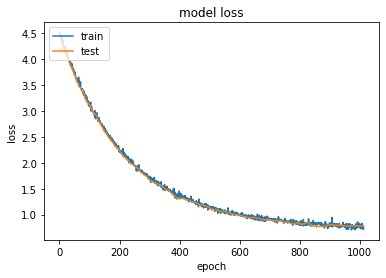

In [61]:
plot_history(history1_gray)

In [59]:
evaluate_list(model1_gray, eval_list_gray, 100)

______________________________
Evaluation for naturale/camera: avg acc=0.71
the accuracy for tree: 1.0
the accuracy for bat: 0.7
the accuracy for monkey: 0.3
the accuracy for house: 0.9
the accuracy for girl: 0.6
the accuracy for car: 0.9
the accuracy for if: 0.5
the accuracy for boy: 0.6
the accuracy for crocodile: 0.6
the accuracy for lion: 1.0
______________________________
Evaluation for naturale/cellulare: avg acc=0.6799999999999999
the accuracy for tree: 1.0
the accuracy for bat: 0.6
the accuracy for monkey: 0.7
the accuracy for house: 0.6
the accuracy for girl: 0.7
the accuracy for car: 0.9
the accuracy for if: 0.5
the accuracy for boy: 0.5
the accuracy for crocodile: 0.6
the accuracy for lion: 0.7
______________________________
Evaluation for artificiale/camera: avg acc=0.7600000000000001
the accuracy for tree: 1.0
the accuracy for bat: 0.5
the accuracy for monkey: 0.7
the accuracy for house: 1.0
the accuracy for girl: 0.9
the accuracy for car: 0.7
the accuracy for if: 0.5
the 